# environment

In [2]:
from rpy2.robjects import r

In [3]:
%load_ext rpy2.ipython

# function prepare

## main

In [48]:
%%R
plot_highest_exprs <- function(mat_filter_path=mat_filter_path, top_n = 20,png_out_path='png/'){
    library(magrittr)
    mat <- read.table(mat_filter_path,sep='\t',header=TRUE,check.names = FALSE)
    name<-c()
    for(i in seq_len(length(rownames(mat)))){
        name[i] <- paste(unlist(strsplit(rownames(mat)[i],"|",fixed=T))[1],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[2],unlist(strsplit(rownames(mat)[i],"|",fixed=T))[3],sep='|')
    }
    row.names(mat)<- name
    mat %>% as_SingleCellExperiment() %>% {suppressMessages(scater::calculateQCMetrics(.))} %>% scater::plotHighestExprs(n = top_n)
}


In [4]:
%%R
count_depth_norm <- function(mat_list=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
                                        "Norm_RLE","Norm_SCnorm","Norm_TMM"),
                             pdf_out_path='pdf/',
                             file_path = "./"){
    allmat=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
             "Norm_RLE","Norm_SCnorm","Norm_TMM")
    library(SCnorm)
    mat_unnorm=read.table(paste(file_path,"scimpute_count.txt",sep=""),header=TRUE,check.names = FALSE)
    par(mfrow=c(2,4))
    for(i in mat_list){
        if(!(i %in% allmat)){
            warning(paste('Check input: ',i,'\tThis normlized matrix is not found\n'))
            next
        }
        #title(main = i)
        mat=read.table(paste(file_path,"filter.null.",i,".domains_combined.txt",sep=""),header=TRUE,check.names = FALSE)
        Conditions = rep(c(1), each= dim(mat)[2])
        countDeptEst <- plotCountDepth(Data = as.matrix(mat_unnorm), NormalizedData = as.matrix(mat), Conditions = Conditions,
                                       FilterCellProportion = .1, NCores=3)
    }
}


In [5]:
%%R
count_depth_unnorm <- function(mat_list='mat_impute',
                               pdf_out_path='pdf/',
                               file_path = "./"){
    allmat='mat_impute'
    library(SCnorm)
    resfactor = 3
    for(i in mat_list){
        if(!(i %in% allmat)){
            warning(paste('Check input: ',i,'\tThis matrix is not found\n'))
            next
        }
        mat=read.table(paste(file_path,"scimpute_count.txt",sep=""))
        #png(paste(pdf_out_path,i,'_count_depth.png',sep=''),res = 72*resfactor, height=640*resfactor, width=640*resfactor)
        Conditions = rep(c(1), each= dim(mat)[2])
        countDeptEst <- plotCountDepth(Data = mat, Conditions = Conditions,
                                       FilterCellProportion = .1, NCores=3)
        #dev.off()
    }
}

In [6]:
%%R
RLE_plot <- function(mat_list=c("Norm_CPM","Norm_CPM_rm","Norm_CPM_top","Norm_null",
                                "Norm_RLE","Norm_SCnorm","Norm_TMM"),
                     impute_method=c("scimpute_count","viper_count","null"),
                     pdf_out_path=".",
                     file_path="."){
    impute_method <- match.arg(impute_method)
    for(i in mat_list)
        assign(i,read.table(paste(file_path,"filter.",impute_method,".",i,".domains_combined.txt",sep=""),header=TRUE))
    reads <- SingleCellExperiment::SingleCellExperiment(
        assays = list(
                      Norm_CPM = as.matrix(Norm_CPM),
                      Norm_CPM_rm = as.matrix(Norm_CPM_rm),
                      Norm_CPM_top = as.matrix(Norm_CPM_top),
                      Norm_RLE = as.matrix(Norm_RLE),
                      Norm_SCnorm = as.matrix(Norm_SCnorm),
                      Norm_TMM = as.matrix(Norm_TMM)))
    res <- list()
    for(n in SummarizedExperiment::assayNames(reads)) {
        res[[n]] <- suppressWarnings(scRNA.seq.funcs::calc_cell_RLE(SummarizedExperiment::assay(reads, n)))
    }
    resfactor = 3 
    par(mar=c(6,4,1,1))
    boxplot(res, las=2,main=paste("RLE of each process after imputation ",impute_method,sep=""),ylab="relative log expression",cex.axis=0.7)
}

In [7]:
%%R
plot_cv_density <- function(cv_mat_path=".", 
                            refer_gene_id_path = ".") {
    refer_gene_id <- read.table(refer_gene_id_path)[,1]
    #refer_gene_name <- read.table(refer_gene_name_path)[,1]
    mat=read.table(cv_mat_path,head=TRUE,check.names = FALSE)
    cv <- mat %>% apply(1, cv_fun) %>%
    {tibble::tibble(id = names(.), value = .)} %>%
    dplyr::mutate(id = stringr::str_extract(id, '[^|]+'))
    plot <- ggplot2::ggplot(cv, ggplot2::aes(value)) +
    ggplot2::geom_density(color = '#5F7AB3') +
    ggplot2::labs(x = 'coefficient of variation')
    refer_gene_name<-c()
    if (length(refer_gene_id) != length(refer_gene_name)) {
        warning("Ignoring refer_gene_name, since it isn't the same length as refer_gene_id")
        refer_gene_name = refer_gene_id
    }
    cv_refer <- tibble::tibble(id = refer_gene_id, name = refer_gene_name) %>%
    dplyr::inner_join(cv, by = 'id')
    if (nrow(cv_refer) == 0L) {
        warning("None refer gene found in the count matrix")
        return(plot)
    }
    
    plot + ggplot2::geom_vline(xintercept = cv_refer$value, color = '#93C991') +
    ggplot2::geom_point(
    ggplot2::aes(x = value, y = seq_y(plot, value)),
    data = cv_refer, size = 2, shape = 1
    ) +
    ggrepel::geom_label_repel(
    ggplot2::aes(x = value, y = seq_y(plot, value), label = name),
    data = cv_refer, hjust = 0.5
    )
}

In [8]:
%%R
anno_contri_var <-function(mat_path=".",
                           batchinfo_path = ".",
                           classinfo_path = "."
                          ){
    mat <- read.table(mat_path,header=TRUE,check.names = FALSE)
    batch_info <- read.csv(batchinfo_path,sep='\t')
    sample_info <-read.csv(classinfo_path,sep='\t')
    names(batch_info)[1]<-"sample_id"
    names(sample_info)[1]<-"sample_id"
    anno_info <- merge(sample_info,batch_info,by='sample_id',all=T)
    rownames(anno_info)=anno_info$sample_id
    anno_info <- anno_info[names(mat),]
    rownames(anno_info) <-c()

    anno_info$class <- 0
    for(i in seq_len(length(table(anno_info$label)))){
        anno_info[which(anno_info$label==names(table(anno_info$label))[i]),]$class <- i
    }
    
    reads <- SingleCellExperiment::SingleCellExperiment(
        assays = list(counts = as.matrix(mat)),
        colData = anno_info
    )
    reads <-  scater::calculateQCMetrics(reads)
    resfactor =3
    for(n in SummarizedExperiment::assayNames(reads)) {
        print(
            scater::plotQC(
                reads,
                type = "expl",
                exprs_values = n,
                variables = c(
                    "total_features",
                    "total_counts",
                    "class",
                    'RNA.Isolation.batch',
                    'library.prepration.day',
                    'gel.cut.size.selection'
                )
            ) +
            ggplot2::ggtitle(n)
        )
    }
}

## utility

In [9]:
%%R
seq_y <- function(plot, x) {
    y_range <- get_y_range(plot)
    by <- diff(y_range) / length(x)
    seq(y_range[1] + by, y_range[2], by) - by/2
}

In [10]:
%%R
get_y_range <-
function(plot) {
    ggplot2::ggplot_build(plot)$layout$panel_params[[1]]$y.range
}

In [11]:
%%R
cv_fun <- function(x) {
    sd(x, na.rm = T) / mean(x, na.rm = T)
}

In [7]:
%%R
as_SingleCellExperiment = function(mat, col_data = NULL) {
    assays = list(counts = as.matrix(mat))
    if (is.null(col_data))
    SingleCellExperiment::SingleCellExperiment(assays = assays)
    else
    SingleCellExperiment::SingleCellExperiment(assays = assays, colData = col_data)
    }


# plot

## prepare

In [49]:
%%R
mat_filter_path='/home/shibinbin/projects/exSeek-dev/output/exorbase/matrix_processing/filter.null.featurecounts.txt'
file_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/"
mat_list = c("Norm_CPM","Norm_CPM_refer","Norm_CPM_rm","Norm_CPM_top","Norm_RLE","Norm_SCnorm","Norm_TMM")
batchinfo_path= "/home/shibinbin/projects/exSeek-dev/data/scirep/batch_info.txt"
classinfo_path = "/home/shibinbin/projects/exSeek-dev/data/scirep/sample_classes.txt"
refer_gene_id_path ="/home/shibinbin/projects/exSeek-dev/data/scirep/reference_genes.txt"
## plot cv using SCnorm mx
cv_mat_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/filter.scimpute_count.Norm_SCnorm.domains_combined.txt"


In [46]:
mat_filter_path='/home/shibinbin/projects/exSeek-dev/output/exorbase/matrix_processing/filter.null.featurecounts.txt'
file_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/"
#mat_list = c("Norm_CPM","Norm_CPM_refer","Norm_CPM_rm","Norm_CPM_top","Norm_RLE","Norm_SCnorm","Norm_TMM")
batchinfo_path= "/home/shibinbin/projects/exSeek-dev/data/scirep/batch_info.txt"
classinfo_path = "/home/shibinbin/projects/exSeek-dev/data/scirep/sample_classes.txt"
refer_gene_id_path ="/home/shibinbin/projects/exSeek-dev/data/scirep/reference_genes.txt"
## plot cv using SCnorm mx
cv_mat_path = "/home/shibinbin/projects/exSeek-dev/output/scirep/matrix_processing/filter.scimpute_count.Norm_SCnorm.domains_combined.txt"


## plot_highest_exprs

In [30]:
import matplotlib.pyplot as plt

In [36]:
%%R
scater::plotHighestExprs

function (object, col_by_variable = "total_features", n = 50, 
    drop_features = NULL, exprs_values = "counts", feature_names_to_plot = NULL) 
{
    if (!(col_by_variable %in% colnames(colData(object)))) {
        stop("col_by_variable not found in colData(object).\n             Please make sure colData(object)[, variable] exists.")
        plot_cols <- FALSE
    }
    else plot_cols <- TRUE
    x <- colData(object)[, col_by_variable]
    typeof_x <- .getTypeOfVariable(object, col_by_variable)
    if (!(is.null(drop_features) | length(drop_features) == 0)) {
        if (is.character(drop_features)) 
            drop_features <- which(rownames(object) %in% drop_features)
        if (is.logical(drop_features)) 
            object <- object[!drop_features, ]
        else object <- object[-drop_features, ]
    }
    if (!is.null(rowData(object)$is_feature_control)) 
        object <- calculateQCMetrics(object, feature_controls = list(all = rowData(object)$is_feature_control))
    else ob

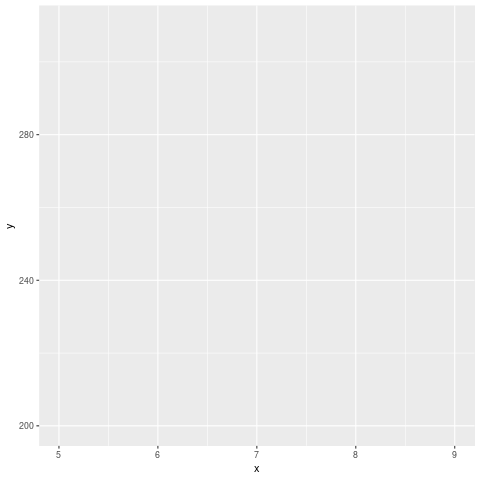

In [41]:
%%R
df_1 = data.frame(x=c(5, 6, 7, 8, 9), y = c(200, 225, 250, 270, 310)) 
options(repr.plot.width = 1, repr.plot.height = 0.75) 
ggplot(df_1, aes(x = x, y = y))

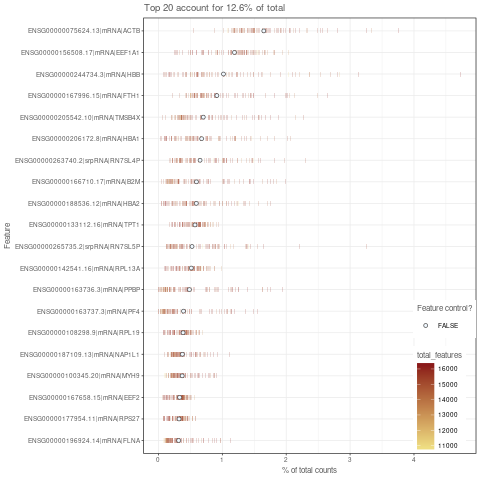

In [52]:
%%R
library(repr) 
options(repr.plot.width=10, repr.plot.height=8) 
plot_highest_exprs(mat_filter_path)

In [32]:
%%R
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
library(ggplot2)
#options(repr.plot.width=4, repr.plot.height=3,repr.plot.res=300)
plot_highest_exprs(mat_filter_path)



Error in plt.rcParams["savefig.dpi"] = 300 : 
  object 'plt.rcParams' not found


/apps/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in plt.rcParams["savefig.dpi"] = 300 : 
  object 'plt.rcParams' not found

  warnings.warn(x, RRuntimeWarning)


## count_depth plot

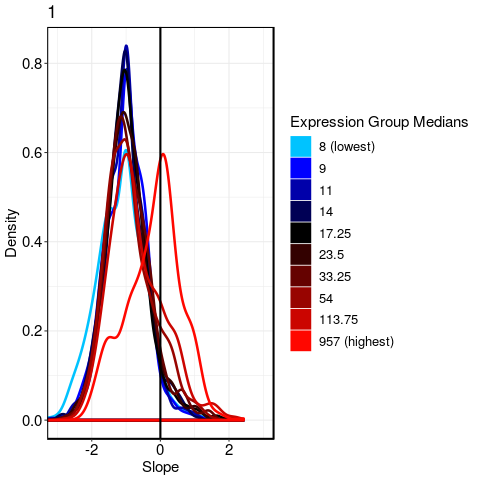

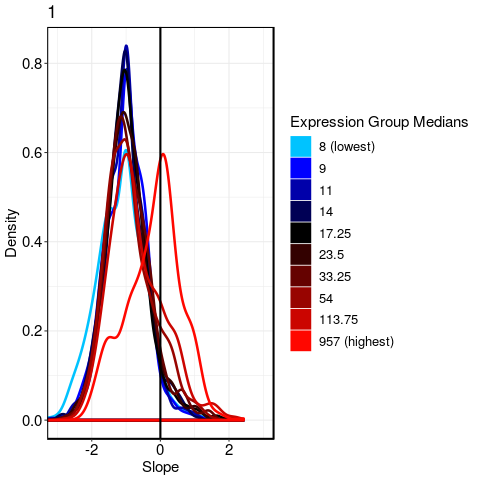

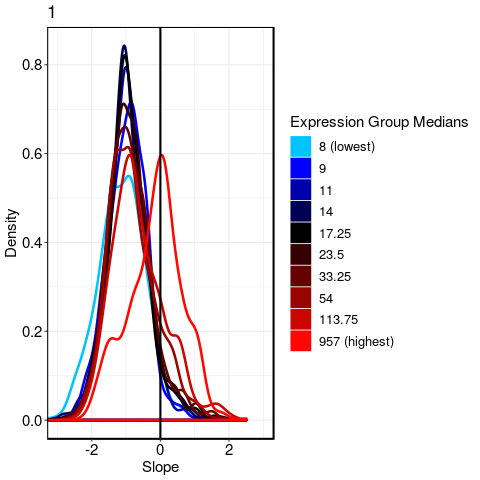

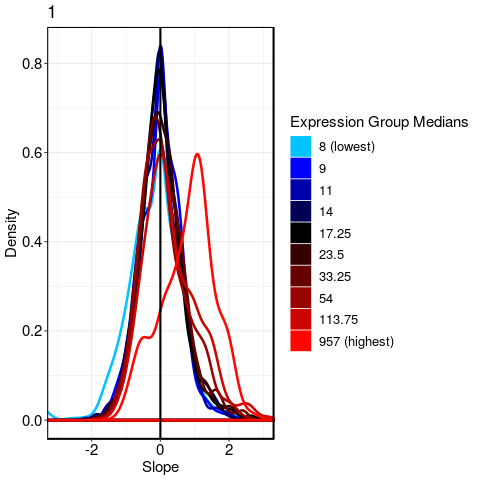

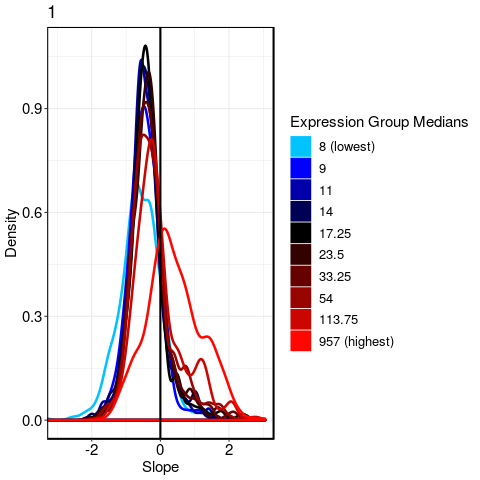

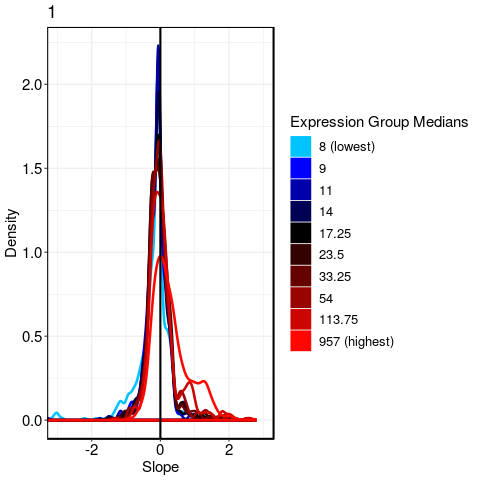

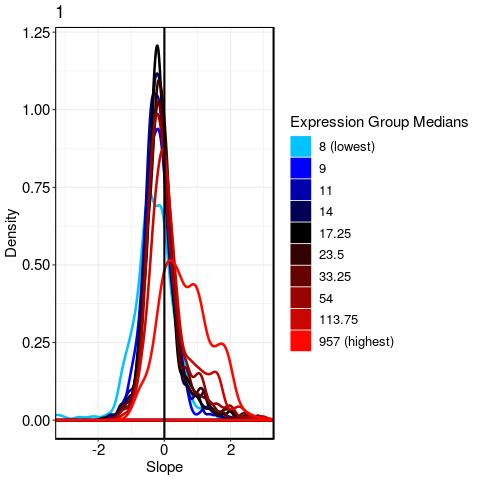

In [15]:
%%R
count_depth_norm(file_path=file_path)

## RLE

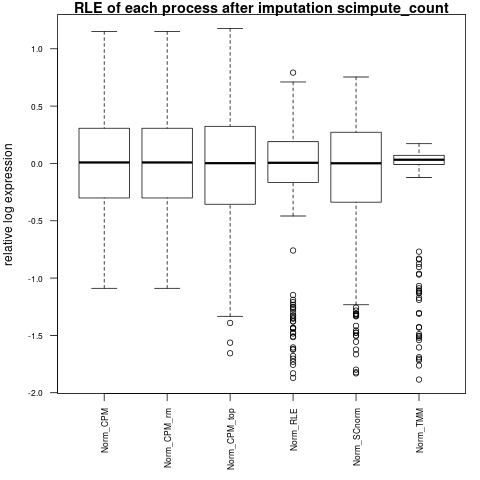

In [16]:
%%R
RLE_plot(file_path=file_path,impute_method="scimpute_count")

## cv density

lack of miRNA, leading to no refer line

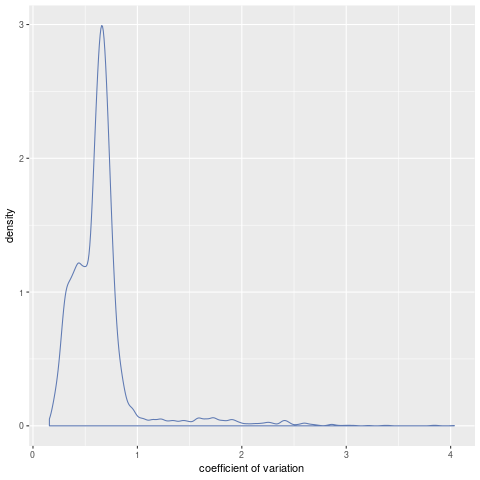

In [17]:
%%R
plot_cv_density(cv_mat_path=cv_mat_path,refer_gene_id_path=refer_gene_id_path)

## anno variables contribute variance plot

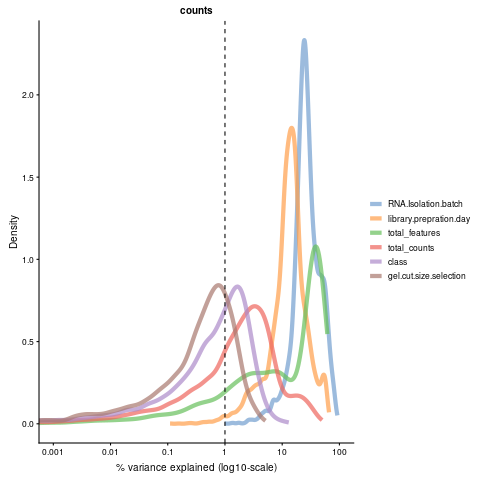

In [18]:
%%R
anno_contri_var(mat_path=cv_mat_path,batchinfo_path=batchinfo_path,classinfo_path=classinfo_path)

# notes


## done
- [x] main plot function
- [x] plot_highest_exprs y_axis names shortened
- [x] R2python
- [x] RLE more common

## to do
- [] pic enlarge
- [] RLE plot of RLE_norm
- [] polish pics
    - [] RLE referring to [source code](https://rdrr.io/bioc/scater/src/R/plotRLE.R)
    - [] count_depth pics par

In [201]:
!pwd

/home/xieyufeng/exSeek
